In [467]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2 import Artifact, Visualization

%matplotlib inline

In [1]:
cd /Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101


In [3]:
! wget https://raw.githubusercontent.com/knightlab-analyses/bloom-analyses/master/data/bloom_taxa.txt

--2021-07-15 10:57:35--  https://raw.githubusercontent.com/knightlab-analyses/bloom-analyses/master/data/bloom_taxa.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3055 (3.0K) [text/plain]
Saving to: ‘bloom_taxa.txt’

bloom_taxa.txt      100%[===================>]   2.98K  --.-KB/s    in 0s      

2021-07-15 10:57:35 (10.4 MB/s) - ‘bloom_taxa.txt’ saved [3055/3055]



In [105]:
bloomdf = pd.read_csv("bloom_taxa.txt", sep="\t")

bloomdf.columns = ['featureid', 'Storage Change', 'Freeze-Thaw change', 'Taxonomy']

#format taxonomy
bloomdf["Taxonomy"] = bloomdf["Taxonomy"].apply(lambda x: "d" + x[1:])
bloomdf["Taxonomy"] = bloomdf["Taxonomy"].apply(lambda x: "; ".join(x.split(";")))

In [126]:
bloomdf.head()

,featureid,Storage Change,Freeze-Thaw change,Taxonomy,Taxonomy (genus)
0,691656f33e727f8857f5c9ee40ed05b1,280.77,56.41,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
1,41f1c6e4d1e4cc653df22555bfab5796,160.78,17.81,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
2,ece1af985b63ebccd2833e9b5f0432e3,138.78,0.85,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
3,04195686f2b70585790ec75320de0d6f,97.38,7.03,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
4,df3f8cdac76c62baa98469c33b82d8df,78.79,2.66,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,d__Bacteria; p__Proteobacteria; c__Gammaproteo...


In [106]:
taxonomy = Artifact.load("taxonomy-silva.qza").view(pd.DataFrame)
taxonomy = taxonomy.reset_index().set_index("Taxon")

In [107]:
taxonomy.index[np.where([x in bloomdf["Taxonomy"].values for x in taxonomy.index])]

Index([], dtype='object', name='Taxon')

**Can see above that it isn't picking up these taxa when classified down to the species level**

In [111]:
bloomdf["Taxonomy (genus)"] = bloomdf["Taxonomy"].apply(lambda x: x.split("; s__")[0])

In [124]:
tofilt = taxonomy.index[np.where([x in bloomdf["Taxonomy (genus)"].values for x in taxonomy.index])]

In [125]:
set(tofilt)

{'d__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus',
 'd__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus',
 'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas'}

In [116]:
set(bloomdf["Taxonomy (genus)"])-set(tofilt)

{'d__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides',
 'd__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Planococcaceae; g__Sporosarcina',
 'd__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus',
 'd__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__',
 'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae',
 'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__',
 'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Citrobacter',
 'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Escherichia',
 'd__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Klebsiella',
 'd__Bacteria; p__Proteobacteria; c__Gammap

## SILVA assigned taxonomy isn't showing up, so I'm going to reclassify based on Greengenes

In [129]:
mkdir reanalysis

In [132]:
!qiime feature-classifier classify-sklearn \
--i-reads dada2-results/representative_sequences.qza \
--i-classifier gg-13-8-99-515-806-nb-classifier.qza \
--o-classification reanalysis/taxonomy-gg.qza

Saved FeatureData[Taxonomy] to: reanalysis/taxonomy-gg.qza


In [141]:
taxonomy = Artifact.load("reanalysis/taxonomy-gg.qza").view(pd.DataFrame)
taxonomy = taxonomy.reset_index().set_index("Taxon")

In [145]:
bloomdf = pd.read_csv("bloom_taxa.txt", sep="\t")
bloomdf.columns = ['featureid', 'Storage Change', 'Freeze-Thaw change', 'Taxonomy']
bloomdf["Taxonomy"] = bloomdf["Taxonomy"].apply(lambda x: "; ".join(x.split(";")))

### We're able to pick out these 7 that are in the AGP bloomed df

In [272]:
tofilt = taxonomy.index[np.where( [(x in bloomdf["Taxonomy"].values) for x in taxonomy.index] )]
set(tofilt)

{'k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__uniformis',
 'k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__clausii',
 'k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus; s__zeae',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Providencia; s__',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas; s__',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas; s__fragi'}

In [273]:
notfound = list(set(bloomdf["Taxonomy"])-set(tofilt))
notfound

['k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__; s__',
 'k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Planococcaceae; g__Sporosarcina; s__ginsengi',
 'k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__; s__',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Klebsiella; s__',
 'k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Escherichia; s__coli',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Trabulsiella; s__farmeri',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Citrobacter; s__',
 'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobac

In [274]:
entero = "k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae"
taxonomy.index[np.where([x.startswith(entero) for x in taxonomy.index])]

Index(['k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae',
       'k__Bacteria; p__Proteobacteria; c_

In [275]:
notfound_genus = [x.split("; s__")[0] for x in notfound]
for tax in notfound_genus:
    print(taxonomy.index[np.where( [(x.startswith(tax)) for x in taxonomy.index] )])

Index(['k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Shigella',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Proteus; s__vulgaris',
    

In [277]:
tofilt = list(tofilt)
tofilt += ['k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Morganella',
           'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Proteus; s__vulgaris']

In [279]:
tofilt = pd.Index(tofilt)

## Actually filtering

In [280]:
tofilt_df = taxonomy.loc[tofilt,"Feature ID"]
#put columns in order
tofilt_df = tofilt_df.reset_index().reindex(["Feature ID", "Taxon"], axis=1)

In [281]:
print(len(tofilt_df["Feature ID"]))
print(len(tofilt_df["Feature ID"].unique()))

905
53


In [282]:
bloomed_sequence_ids = pd.Series(tofilt_df["Feature ID"].unique(),name="Feature ID")

In [283]:
bloomed_sequence_ids.to_csv("reanalysis/bloomed_sequence_ids.tsv", sep="\t", index=False)

In [284]:
!qiime feature-table filter-features \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file reanalysis/bloomed_sequence_ids.tsv \
--p-exclude-ids \
--o-filtered-table reanalysis/nobloom-table.qza

Saved FeatureTable[Frequency] to: reanalysis/nobloom-table.qza


In [285]:
viz = Visualization.load("noMito_noChloro-filtered-table.qzv")
viz

<visualization: Visualization uuid: e19c142b-48a2-4b33-9926-d5a60bb10022>

In [286]:
! qiime feature-table summarize \
--i-table reanalysis/nobloom-table.qza \
--m-sample-metadata-file Categorical-meta-v3.tsv \
--o-visualization reanalysis/nobloom-table.qzv

Saved Visualization to: reanalysis/nobloom-table.qzv


In [287]:
viz = Visualization.load("reanalysis/nobloom-table.qzv")
viz

<visualization: Visualization uuid: bbf5a825-dc2e-41e8-afcd-aaa503a9a111>

In [288]:
! qiime feature-table filter-samples \
--i-table reanalysis/nobloom-table.qza \
--m-metadata-file expr-group-metadata.tsv \
--o-filtered-table reanalysis/nobloom-filt-table.qza

Saved FeatureTable[Frequency] to: reanalysis/nobloom-filt-table.qza


In [289]:
! qiime taxa barplot \
--i-table reanalysis/nobloom-filt-table.qza \
--i-taxonomy reanalysis/taxonomy-gg.qza \
--m-metadata-file expr-group-metadata.tsv \
--o-visualization reanalysis/taxa-barplot-gg.qzv

Saved Visualization to: reanalysis/taxa-barplot-gg.qzv


In [290]:
viz = Visualization.load("reanalysis/taxa-barplot-gg.qzv")
viz

<visualization: Visualization uuid: ede6bcbc-5307-4fb6-82f3-d30fb0d68beb>

**Still a lot more Proteobacteria than we want to see**

## Filtering using the fna and filter-seqs

In [306]:
!qiime tools peek dada2-results/representative_sequences.qza

UUID:        7df786ab-1917-43fd-9d00-88611a2411cc
Type:        FeatureData[Sequence]
Data format: DNASequencesDirectoryFormat


In [311]:
!wget https://raw.githubusercontent.com/knightlab-analyses/bloom-analyses/master/data/newbloom.all.fna

--2021-07-16 11:08:34--  https://raw.githubusercontent.com/knightlab-analyses/bloom-analyses/master/data/newbloom.all.fna
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3699 (3.6K) [text/plain]
Saving to: ‘newbloom.all.fna’

newbloom.all.fna    100%[===================>]   3.61K  --.-KB/s    in 0s      

2021-07-16 11:08:34 (11.8 MB/s) - ‘newbloom.all.fna’ saved [3699/3699]



In [328]:
!qiime tools export \
--input-path dada2-results/representative_sequences.qza \
--output-path dada2-results/repseqs_export 

Exported dada2-results/representative_sequences.qza as DNASequencesDirectoryFormat to directory dada2-results/repseqs_export


In [330]:
ls dada2-results/repseqs_export/

dna-sequences.fasta


In [371]:
from Bio import SeqIO

# parse sequence fasta file
identifiers = [seq_record.id for seq_record in SeqIO.parse("dada2-results/repseqs_export/dna-sequences.fasta",
                                                           "fasta")]
seqs = [str(seq_record.seq) for seq_record in SeqIO.parse("dada2-results/repseqs_export/dna-sequences.fasta",
                                                             "fasta")]

In [373]:
seqs_dict = dict(zip(identifiers, seqs))

In [336]:
!qiime tools export \
--input-path dada2-results/table.qza \
--output-path dada2-results

Exported dada2-results/table.qza as BIOMV210DirFmt to directory dada2-results


In [337]:
from biom import Table, load_table, 
from biom.util import biom_open

In [437]:
biom_df = load_table("dada2-results/feature-table.biom").to_dataframe()
biom_df = biom_df.reset_index()
print(biom_df.shape)

(3805, 47)


In [438]:
biom_df["Sequence"] = biom_df["index"].apply(lambda x: seqs_dict[x])

In [439]:
bloom_seqs = [str(seq_record.seq) for seq_record in SeqIO.parse("newbloom.all.fna",
                                                             "fasta")]

In [440]:
print(min(map(len, bloom_seqs)))
print(min(map(len, biom_df["Sequence"])))

150
295


In [441]:
biom_df["to_drop"] = biom_df["Sequence"].apply(lambda x: sum([seq in x for seq in bloom_seqs])>0)
biom_filt_df = biom_df[biom_df["to_drop"]==False]

In [445]:
biom_filt_df = biom_filt_df.drop(["Sequence", "to_drop"], axis=1).rename(columns={"index":"#OTU ID"}).set_index("#OTU ID")

In [446]:
biom_filt_df.to_csv("filt-seq-table.tsv", sep="\t")

In [449]:
!biom convert -i filt-seq-table.tsv -o filt-seq-table.biom --to-hdf5 --table-type="OTU table"

## Let's look at what we filtered

In [543]:
filtered_df = biom_df[biom_df["to_drop"]==True]
filtered_df = filtered_df.drop(["Sequence", "to_drop"], axis=1).rename(columns={"index":"#OTU ID"}).set_index("#OTU ID")

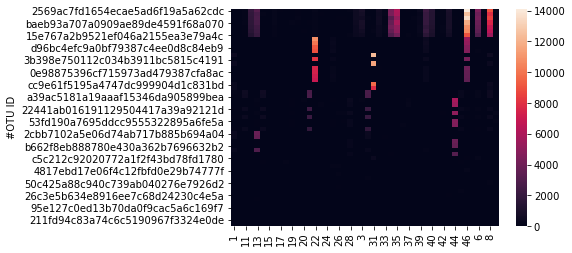

In [544]:
sns.heatmap(filtered_df)

In [545]:
taxonomy = taxonomy.reset_index().set_index("Feature ID")
filtered_df["Taxon"] = taxonomy.loc[filtered_df.index]["Taxon"]

In [546]:
filtered_df_tax = filtered_df.set_index("Taxon")

In [510]:
filtered_df_tax.shape

(53, 46)

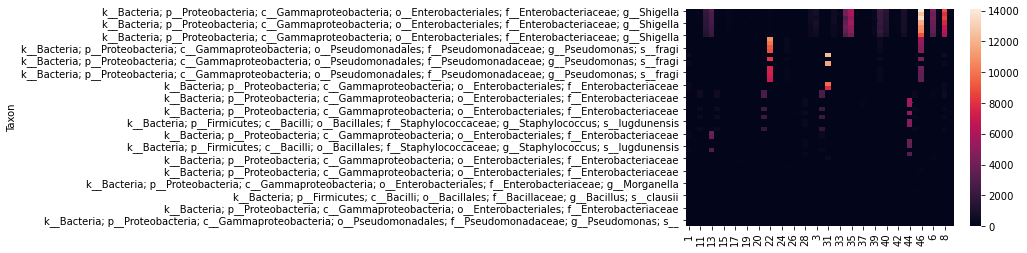

In [548]:
sns.heatmap(filtered_df_tax)
plt.show()

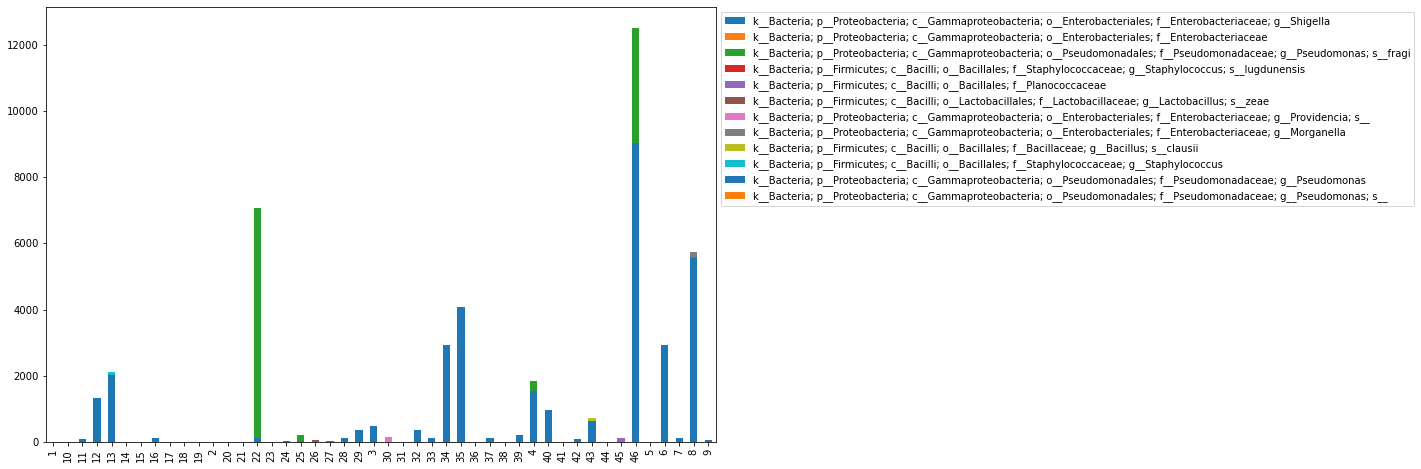

In [549]:
ax = filtered_df_tax.T.plot(kind='bar', stacked=True,)
ax.legend(bbox_to_anchor=[1,1])

plt.gcf().set_size_inches(12,8)
plt.show()

In [566]:
filtered_df_tax_rel_mat = np.matrix(filtered_df_tax) / np.sum(np.matrix(biom_df.drop(["index","Sequence","to_drop"], axis=1)),
                                                                     axis=0)

In [567]:
filtered_df_tax_rel = pd.DataFrame(filtered_df_tax_rel_mat,
                                   index=filtered_df_tax.index,
                                   columns=filtered_df_tax.columns)

In [575]:
filtered_df_tax_rel = filtered_df_tax_rel.reset_index().groupby("Taxon").sum()

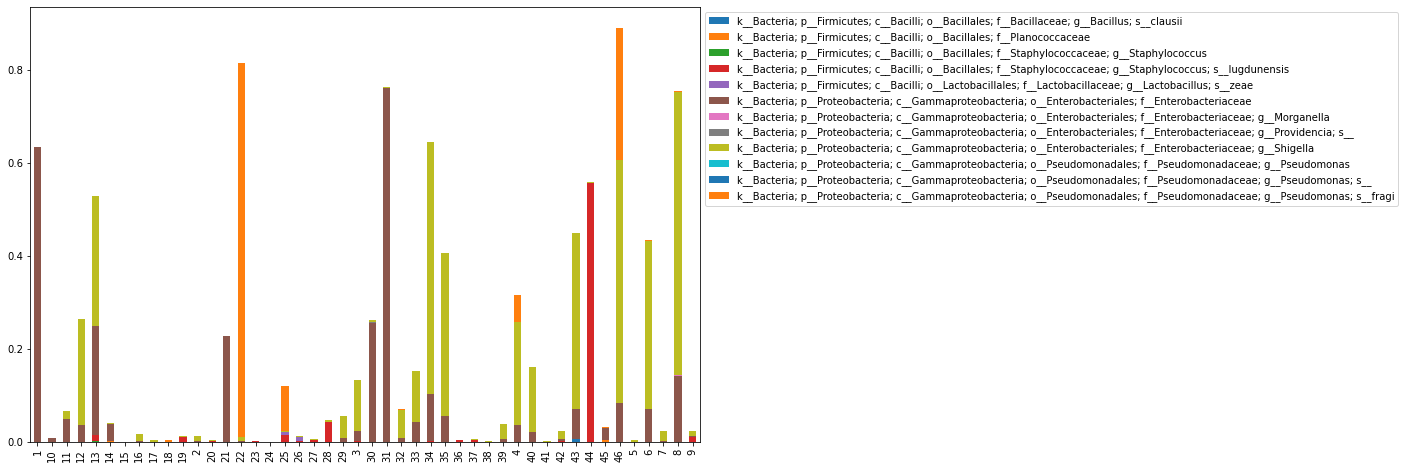

In [584]:
ax = filtered_df_tax_rel.T.plot(kind='bar', stacked=True,)
ax.legend(bbox_to_anchor=[1,1])

plt.gcf().set_size_inches(12,8)
plt.show()

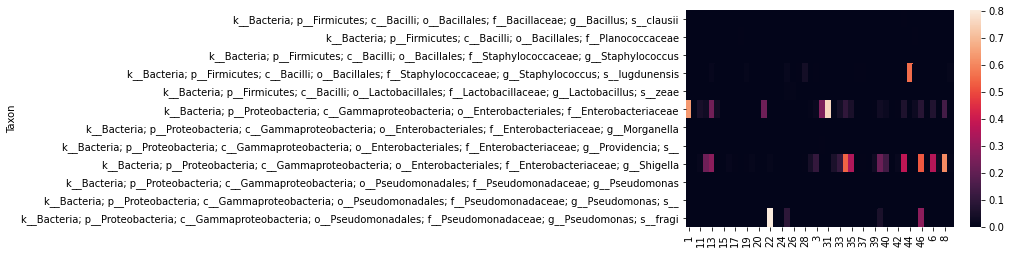

In [585]:
sns.heatmap(filtered_df_tax_rel)
plt.show()

In [587]:
filtered_df_tax_rel.max().max()

0.8044016216500817

## Make a Taxa barplot from new filtered table

In [453]:
!qiime tools import \
--type FeatureTable[Frequency] \
--input-path filt-seq-table.biom \
--output-path filt-seq-table.qza

Imported filt-seq-table.biom as BIOMV210DirFmt to filt-seq-table.qza


In [524]:
mkdir reanalysis-2

In [525]:
!qiime feature-table filter-samples \
--i-table filt-seq-table.qza \
--m-metadata-file expr-group-metadata.tsv \
--o-filtered-table reanalysis-2/samp-filt-seq-table.qza

Saved FeatureTable[Frequency] to: reanalysis-2/samp-filt-seq-table.qza


In [526]:
mv expr-group-metadata.tsv reanalysis-2/expr-group-metadata.tsv

In [527]:
cp reanalysis/taxonomy-gg.qza reanalysis-2/taxonomy-gg.qza

In [528]:
!qiime taxa barplot \
--i-table reanalysis-2/samp-filt-seq-table.qza \
--i-taxonomy reanalysis-2/taxonomy-gg.qza \
--m-metadata-file reanalysis-2/expr-group-metadata.tsv \
--o-visualization reanalysis-2/filt-seq-taxa-barplot.qzv

Saved Visualization to: reanalysis-2/filt-seq-taxa-barplot.qzv


In [529]:
Visualization.load("reanalysis-2/filt-seq-taxa-barplot.qzv")

<visualization: Visualization uuid: 51dd4d1a-3221-419a-9332-1c4d5539877b>

## Assess the one left that appears to have a bloom

In [690]:
metadata = pd.read_csv("reanalysis-2/expr-group-metadata.tsv", sep="\t")
metadata.loc[metadata["plate.sample.id"]=="1035", ["sampleid", "Chemotherapy"]]

,sampleid,Chemotherapy
24,33,Breast Cancer


In [622]:
biom_filt_df_tax = biom_filt_df
biom_filt_df_tax["Taxon"] = taxonomy.loc[biom_filt_df_tax.index]["Taxon"]

In [625]:
biom_filt_df_tax = biom_filt_df_tax.set_index("Taxon")

In [636]:
biom_filt_mat_tax = np.matrix(biom_filt_df_tax)
biom_filt_mat_tax /= np.sum(biom_filt_mat_tax, axis=0)

biom_filt_df_tax = pd.DataFrame(biom_filt_mat_tax,
                                index=biom_filt_df_tax.index,
                                columns=biom_filt_df_tax.columns)

In [641]:
proteo = biom_filt_df_tax.reset_index()["Taxon"].apply(lambda x: x.startswith("k__Bacteria; p__Proteobacteria"))

In [638]:
sum(proteo)

141

In [653]:
proteo = [tax.startswith("k__Bacteria; p__Proteobacteria") for tax in biom_filt_df_tax.index]

In [727]:
biom_filt_df_tax.loc[proteo, "33"][biom_filt_df_tax.loc[proteo, "33"]>0.01]

Taxon
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Comamonadaceae                   0.104032
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Comamonadaceae                   0.103386
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Comamonadaceae                   0.096278
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Comamonadaceae                   0.091626
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Comamonadaceae                   0.088136
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Comamonadaceae                   0.077022
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Brucellaceae; g__Ochrobactrum       0.015766
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Alcaligenaceae; g__Bordetella    0.013828
Name: 33, dtype: float64

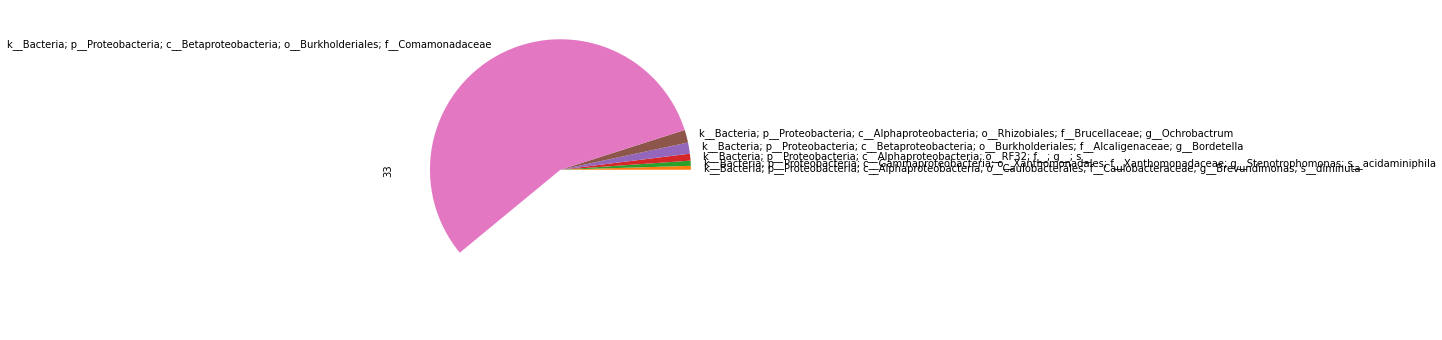

In [739]:
biom_filt_df_tax.loc[proteo, "33"].reset_index().groupby("Taxon").sum().sort_values(by="33").plot(kind="pie", 
                                                                                                 subplots=True, 
                                                                                                 legend=False)
plt.gcf().set_size_inches(10,6)
plt.show()

In [740]:
biom_filt_df_tax.loc[proteo, "33"].reset_index().groupby("Taxon").sum().sort_values(by="33")

,33
Taxon,
k__Bacteria; p__Proteobacteria,0.000000
k__Bacteria; p__Proteobacteria; c__Deltaproteobacteria; o__Desulfovibrionales; f__Desulfovibrionaceae; g__; s__,0.000000
k__Bacteria; p__Proteobacteria; c__Deltaproteobacteria; o__Desulfovibrionales; f__Desulfovibrionaceae; g__Bilophila; s__,0.000000
k__Bacteria; p__Proteobacteria; c__Deltaproteobacteria; o__Desulfovibrionales; f__Desulfovibrionaceae; g__Desulfovibrio; s__,0.000000
k__Bacteria; p__Proteobacteria; c__Epsilonproteobacteria; o__Campylobacterales; f__Campylobacteraceae; g__Campylobacter; s__,0.000000
k__Bacteria; p__Proteobacteria; c__Epsilonproteobacteria; o__Campylobacterales; f__Campylobacteraceae; g__Campylobacter; s__rectus,0.000000
k__Bacteria; p__Proteobacteria; c__Epsilonproteobacteria; o__Campylobacterales; f__Campylobacteraceae; g__Campylobacter; s__ureolyticus,0.000000
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Aeromonadales; f__Aeromonadaceae; g__Aeromonas,0.000000
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae,0.000000


In [742]:
ls reanalysis-2/

expr-group-metadata.tsv    samp-filt-seq-table.qza
filt-seq-taxa-barplot.qzv  taxonomy-gg.qza


In [748]:
nobloom_metadata = metadata.loc[metadata["sampleid"]!=33]

In [750]:
nobloom_metadata.to_csv("reanalysis-2/nobloom_metadata.tsv", sep="\t", index=False)

In [752]:
!qiime feature-table filter-samples \
--i-table reanalysis-2/samp-filt-seq-table.qza \
--m-metadata-file reanalysis-2/nobloom_metadata.tsv \
--o-filtered-table reanalysis-2/nobloom_table.qza

Saved FeatureTable[Frequency] to: reanalysis-2/nobloom_table.qza
